In [1]:
# Try out the variable star on Channel 33! ktwo227825246
from astropy.io import fits as pyfits
import matplotlib.pyplot as pl
import glob
import os
from tqdm import tqdm
from scipy.ndimage.measurements import label
import tensorflow as tf
from scipy.signal import savgol_filter
import numpy as np
%matplotlib inline

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [40]:
def SavGol(y, win=49):
    if len(y) >= win:
        return y - savgol_filter(y, win, 2) + np.nanmedian(y)
    else:
        return y

    
def Interpolate(time, mask, y):
    yy = np.array(y)
    t_ = np.delete(time, mask)
    y_ = np.delete(y, mask, axis=0)
    if len(yy.shape) == 1:
        yy[mask] = np.interp(time[mask], t_, y_)
    elif len(yy.shape) == 2:
        for n in range(yy.shape[1]):
            yy[mask, n] = np.interp(time[mask], t_, y_[:, n])
    else:
        raise Exception("Array ``y`` must be either 1- or 2-d.")
    return yy


def InterpolateOverOutliers(target_lc, tol=3, win=49):
    f = SavGol(target_lc, win)
    med = np.nanmedian(target_lc)
    MAD = 1.4826 * np.nanmedian(np.abs(f - med))
    outliers = np.where((f > med + tol * MAD) | (f < med - tol * MAD))[0]
    target_lc = Interpolate(time, outliers, target_lc)
    return target_lc


def InterpolateOverFlags(target_lc, flags):
    outliers = np.where(flags > 0)[0]
    target_lc = Interpolate(time, outliers, target_lc)
    return target_lc


def getMask(y, sigma=5, win=49):
    f = SavGol(y, win)
    med = np.nanmedian(f)
    MAD = 1.4826 * np.nanmedian(np.abs(f - med))
    mask = np.ones(len(time), dtype=bool)
    mask[np.where((f > med + sigma * MAD) | (f < med - sigma * MAD))] = 0
    return mask


def getFlux(nsources=None):
    """Return the postage stamps for C91."""
    satlim = 150000
    flux = []
    flags = []
    files = glob.glob('data/c91/*/*/*.fits.gz')
    nantime = None
    time = None
    if nsources is None:
        nsources = len(files)
    for file in tqdm(files[:nsources]):
        
        # Skip short cadence
        if pyfits.getheader(file, 0)['OBSMODE'] == 'short cadence':
            continue
        
        with pyfits.open(file) as f:
            
            # Get the time array
            if time is None:
                time = f[1].data['TIME']
                nans = np.where(np.isnan(time))
                time = np.delete(time, nans)
            else:
                assert np.allclose(np.delete(f[1].data['TIME'], nans, axis=0), time), "Mismatch in time array."
            
            # Get the flux
            ftmp = np.delete(f[1].data['FLUX'], nans, axis=0)
            
            # Reject saturated stars
            if np.nanmax(ftmp) < satlim:
                flux.append(ftmp)
                flags.append(np.delete(f[1].data['QUALITY'], nans))

    return time, flux, flags

In [41]:
def getData(clobber=False):
    """Get all the data we'll need."""
    if clobber or not os.path.exists("c9.npz"):
        # Get the flux
        time, flux, flags = getFlux()

        # This is the postage stamp with targets we're gonna de-trend
        target_ind = 1059
        target_lcs = []
        for rows, cols in zip([slice(37, 41), slice(16, 20), slice(54, 58)], 
                              [slice(15, 20), slice(9, 14), slice(45, 50)]):
            target = np.array(flux[target_ind][:, rows, cols])
            target_flags = flags[target_ind]
            target_lc = np.nansum(target, axis=(1, 2))
            target_lc = target_lc / np.nanmedian(target_lc) - 1
            target_lc = InterpolateOverFlags(target_lc, target_flags)
            target_lc = InterpolateOverOutliers(target_lc, 2)
            target_lcs.append(target_lc)

        # Remove it from the image so we don't use it as a regressor.
        flux = flux[:target_ind] + flux[target_ind + 1:]
        
        # Label sources at 40 sigma and use them as regressors
        lcs = []
        lc_flags = []
        for f, flg in tqdm(zip(flux, flags)):
            img = np.nanmedian(f, axis=0)
            mu = np.nanmedian(img)
            sigma = np.sqrt(np.nanmedian((img - mu) ** 2))
            m = (img - mu) > 40 * sigma
            m &= np.isfinite(img) 
            labels, nstar = label(m)
            if nstar > 0:
                for star in range(nstar):
                    lcs.append(np.sum(f[:, labels == star + 1], axis=1))
                    lc_flags.append(flg)

        # Normalize the regressors & remove outliers
        lcs = lcs / np.median(lcs, axis=-1)[:, None] - 1
        for i, lc in enumerate(lcs):
            lcs[i] = InterpolateOverFlags(lcs[i], lc_flags[i])
            lcs[i] = InterpolateOverOutliers(lcs[i], 2) 

        # Save it
        np.savez("c9.npz", time=time, target_lcs=target_lcs, lcs=lcs)
    
    else:
        
        # Load it
        data = np.load("c9.npz")
        time = data['time']
        target_lc = data['target_lc']
        lcs = data['lcs']
        
    return time, target_lcs, lcs

In [42]:
# Get the data
time, target_lcs, lcs = getData(clobber=True)

100%|██████████| 3429/3429 [18:44<00:00,  3.05it/s]
0it [00:00, ?it/s]/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:907: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
2545it [01:25, 29.80it/s]


In [58]:
# Tensorflow setup
T = tf.float32
np.random.seed(42)
lam_lc1 = 1
lam_lc2 = 1
lam_pol = 1
nlc1 = len(lcs)
nlc2 = len(lcs)
npol = 50
target_lc = target_lcs[0]

# Indices of the weights
idx_lc1 = slice(0, nlc1)
idx_lc2 = slice(nlc1, nlc1 + nlc2)
idx_pol = slice(nlc1 + nlc2, nlc1 + nlc2 + npol)

# New session
session = tf.get_default_session()
if session is None:
    session = tf.InteractiveSession()

# Target flux
y = tf.constant(target_lc, dtype=T)

# Design matrix
X = np.hstack([lcs.T, 
               lcs.T ** 2, 
               np.vander(np.linspace(0, 1, len(time)), N=npol, increasing=True)])
X = tf.constant(X, dtype=T)

# Outlier mask
mask = tf.constant(np.ones(len(time), dtype=bool), dtype=tf.bool)

# Initial (random) guess at the model
A0 = X.eval()
w0 = np.random.randn(nlc1 + nlc2 + npol)
w = tf.Variable(w0, dtype=T)
mod = tf.squeeze(tf.matmul(X, w[:, None]))

# Regularization strengths
lam_lc1 = tf.constant(lam_lc1, dtype=T)
lam_lc2 = tf.constant(lam_lc2, dtype=T)
lam_pol = tf.constant(lam_pol, dtype=T)

# Loss function
loss0 = tf.reduce_sum(tf.boolean_mask((y - mod)**2, mask))
loss1 = lam_lc1 * tf.reduce_sum(tf.abs(w[idx_lc1])) + \
        lam_lc2 * tf.reduce_sum(tf.abs(w[idx_lc2])) + \
        lam_pol * tf.reduce_sum(w[idx_pol] ** 2)
loss = loss0 + loss1

# Simple gradient descent optimizer
opt = tf.train.AdamOptimizer(1e-4).minimize(loss)

# Zé's iterative L2 method
XTX = tf.matmul(X, X, transpose_a=True)
XTy = tf.matmul(X, y[:, None], transpose_a=True)
bk1 = tf.reduce_sum(tf.abs(w[idx_lc1]))
bk2 = tf.reduce_sum(tf.abs(w[idx_lc2]))
wk = tf.squeeze(tf.linalg.solve(XTX + (lam_lc1 / bk1 + lam_lc2 / bk2 + lam_pol) * tf.eye(nlc1 + nlc2 + npol), XTy))
opt_ze = tf.assign(w, wk)

# Initialize the session
init = tf.global_variables_initializer()
session.run(init)

In [66]:
def Detrend(target_lc, outlier_mask, lam=[5e-1, 5e-1, 1e-5], nadam=0):
    """Detrend!"""
    session.run(init)
    feed_dict = {mask: outlier_mask, 
                 lam_lc1: lam[0], 
                 lam_lc2: lam[1],
                 lam_pol: lam[2],
                 y: target_lc}

    # Zé's method
    losses = []
    old_loss = loss.eval()
    old_w = w.eval()
    nze = 0
    while True:
        session.run(opt_ze, feed_dict=feed_dict)
        new_loss = loss.eval()
        if new_loss > old_loss:
            fd = dict(feed_dict)
            fd[wk] = old_w
            session.run(opt_ze, feed_dict=fd)
            break
        losses.append(new_loss)
        old_loss = new_loss
        old_w = w.eval()
        nze += 1
    
    # Gradient descent
    for j in range(nadam):
        session.run(opt, feed_dict=feed_dict)
        losses.append(loss.eval())
    
    # Show losses
    fig = pl.figure(figsize=(12, 4))
    pl.plot(losses, alpha=0.5);
    pl.axvline(nze, color='k', ls='--');
    pl.yscale("log");
    pl.xlabel("Iteration");
    pl.ylabel("Loss");

    # Show weights
    fig, ax = pl.subplots(1, 3, figsize=(12, 4))
    ax[0].plot(w.eval()[idx_lc1]);
    ax[1].plot(w.eval()[idx_lc2]);
    ax[2].plot(w.eval()[idx_pol]);
    ax[0].set_ylabel("weight")
    for axis in ax:
        ymin, ymax = axis.get_ylim()
        ymax = max(np.abs(ymin), ymax)
        axis.set_ylim(-ymax, ymax)
        axis.set_xlabel("index")

    # Show model and data
    fig = pl.figure(figsize=(12, 4))
    pl.plot(time, 1 + target_lc);
    pl.plot(time, 1 + mod.eval());
    pl.xlabel("time");
    pl.ylabel("flux");

    # Show de-trended
    fig = pl.figure(figsize=(12, 4))
    mod_lc1 = np.dot(X.eval()[:, idx_lc1], w.eval()[idx_lc1])
    mod_lc2 = np.dot(X.eval()[:, idx_lc2], w.eval()[idx_lc2])
    mod_pol = np.dot(X.eval()[:, idx_pol], w.eval()[idx_pol])
    pl.plot(time, 1 + target_lc - (mod_lc1 + mod_lc2));
    pl.xlabel("time");
    pl.ylabel("flux");

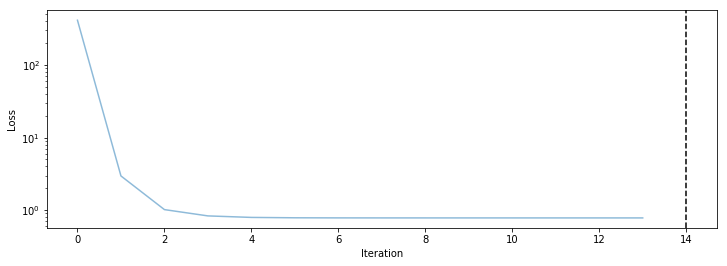

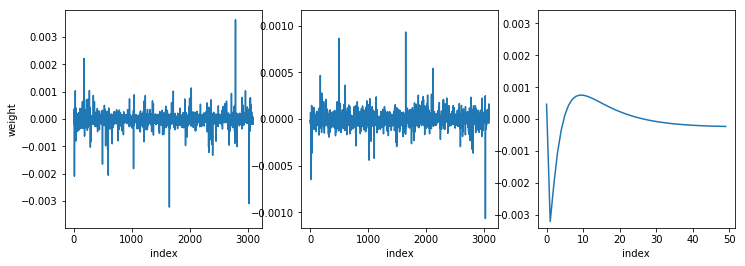

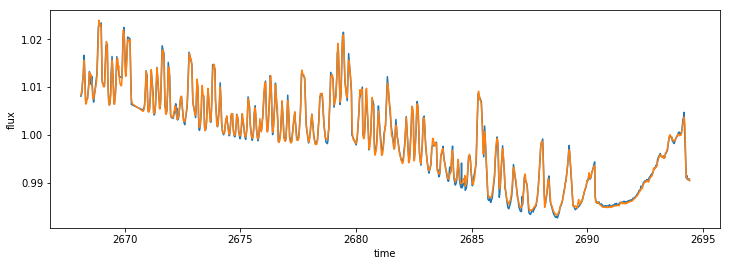

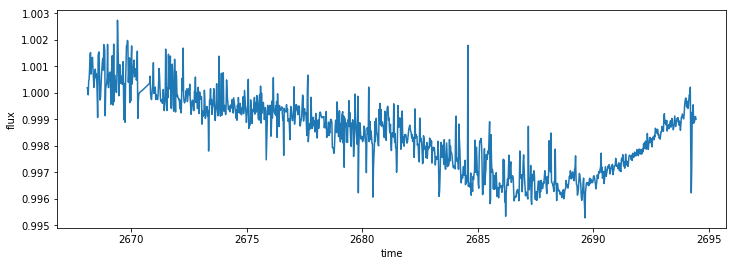

In [69]:
# De-trend just with Zé, no outliers
outlier_mask = np.ones(len(time), dtype=bool)
target_lc = target_lcs[2]
Detrend(target_lc, outlier_mask, lam=[5e-1, 5e-1, 1e-5], nadam=0)

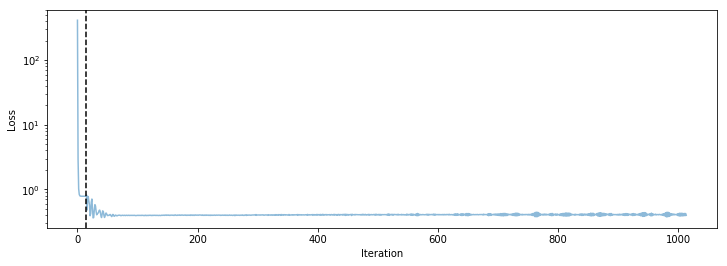

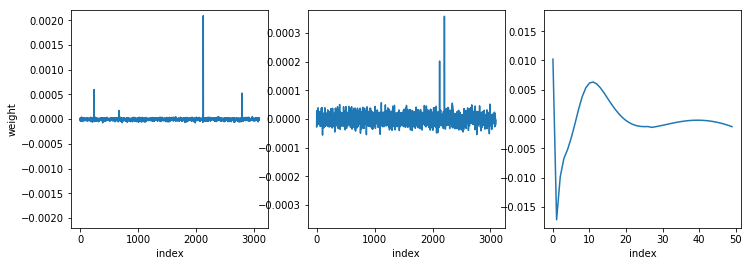

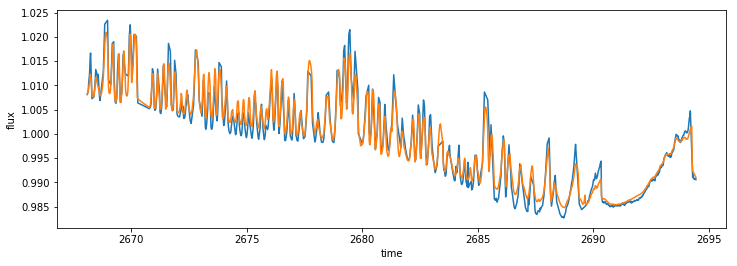

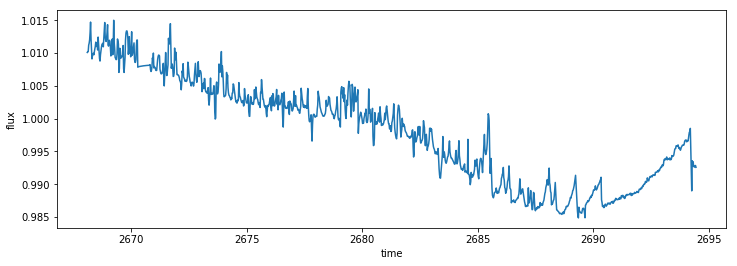

In [68]:
# De-trend just with Zé + Adam, no outliers
outlier_mask = np.ones(len(time), dtype=bool)
target_lc = target_lcs[2]
Detrend(target_lc, outlier_mask, lam=[5e-1, 5e-1, 1e-5], nadam=1000)